# An Initialization Study: How do k-Means and k-Medians compare under different initializations?
### Author: Daniel Wang

In [1]:
import math
import numpy as np
import sklearn.preprocessing as skpp
import sklearn.datasets as skds

import time
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns

import sys
import os
cwd = os.getcwd()
sys.path.append(cwd + '/modules/')

from kgencenters import KGenCenters # this is our custom class

## Toy Datasets

In [2]:
# Define a random seed for reproducibility
seed = 0

# Generate synthetic datasets for clustering
n_samples = 500  # Number of data points in each dataset

# Generate isotropic Gaussian blobs that are trickily separated
centers = [[0, 0], [0, 6], [20, 3]]  # Three main clusters
separated_blobs = skds.make_blobs(n_samples=n_samples, centers=centers, random_state=seed)

# Generate Gaussian blobs with varied variances
varied_scale = skds.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)

### Choose Which Dataset to Activate
#### (the dataset separated_blobs is perfectly separable while the dataset varied_scale is not)

In [3]:
# Transform the data to have zero mean and unit variance

X = skpp.StandardScaler().fit_transform(separated_blobs[0])
y = separated_blobs[1]

# X = skpp.StandardScaler().fit_transform(varied_scale[0])
# y = varied_scale[1]

### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [4]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
accuracies = np.zeros((6,2))
# Store the success rate
success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(y)
        # Compute the mean of the accuracies
        accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        accuracy_dict[init][cost] = acc_record


#### The following cell is for visualizing histograms *ad hoc* (leave this section collapsed)

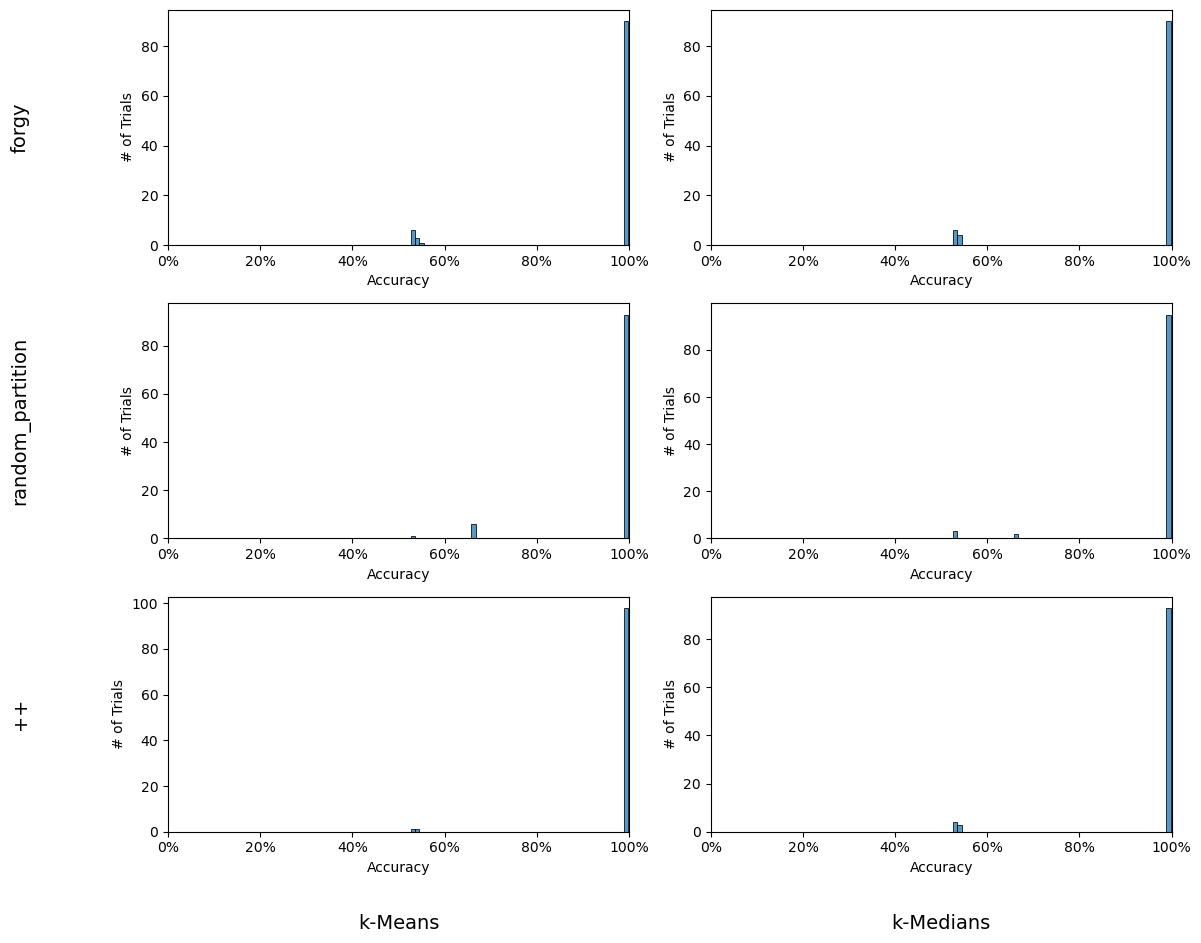

In [5]:
# Generate six histograms from accuracy_dict
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Format x-axis labels as percentages
percent_formatter = ticker.PercentFormatter(xmax=1, decimals=0)

for j, init in enumerate(initializations):
    for i, cost in enumerate(cost_metrics):
        sns.histplot(accuracy_dict[init][cost], ax=axes[j, i], bins=50)
        axes[j, i].set_xlabel('Accuracy', fontsize=10)
        axes[j, i].set_ylabel('# of Trials', fontsize=10)
        axes[j, i].xaxis.set_major_formatter(percent_formatter)
        axes[j, i].set_xlim(0, 1)
        axes[j, i].set_ylim(0, None)

# Add initialization names to the left of the entire plot
for j, init in enumerate(initializations):
    axes[j, 0].annotate(init, xy=(-0.3, 0.5), xycoords='axes fraction', fontsize=14,
                        horizontalalignment='right', verticalalignment='center', rotation='vertical')

# Add labels for k-Means and k-Medians below the entire plot
axes[2, 0].annotate('k-Means', xy=(0.5, -0.35), xycoords='axes fraction', fontsize=14,
                    horizontalalignment='center', verticalalignment='top')
axes[2, 1].annotate('k-Medians', xy=(0.5, -0.35), xycoords='axes fraction', fontsize=14,
                    horizontalalignment='center', verticalalignment='top')

# Adjust spacing and layout
plt.tight_layout(rect=(0, 0.05, 1, 1))

# Remove the default titles above each subplot
for ax in axes.flat:
    ax.set_title('')

plt.show()


### Results

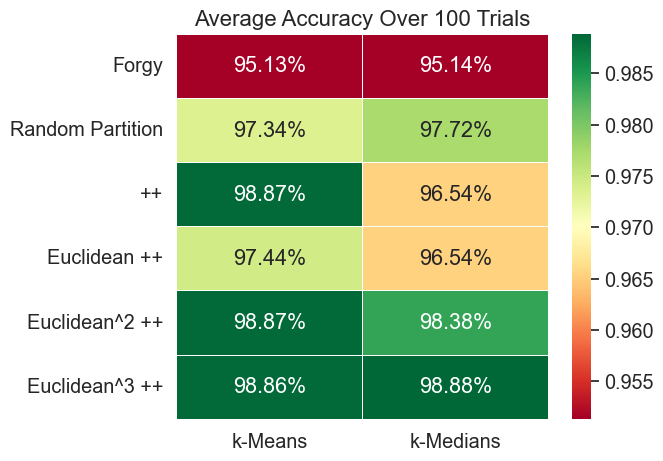

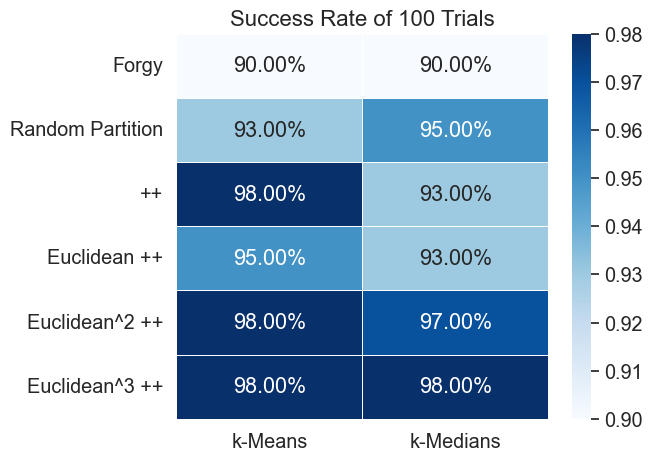

In [6]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
df_accuracies = pd.DataFrame(accuracies, index=initializations_labels, columns=['k-Means', 'k-Medians'])
df_success_rate = pd.DataFrame(success_rate, index=initializations_labels, columns=['k-Means', 'k-Medians'])

# Setting the font scale (size)
sns.set(font_scale=1.3)

# Creating the heatmap for accuracies with the specified colormap
cmap = sns.color_palette("RdYlGn", as_cmap=True)
fig, ax1 = plt.subplots(figsize=(6, 5))
sns.heatmap(df_accuracies, annot=True, cmap=cmap, fmt=".2%", linewidths=.5, cbar=True, ax=ax1)
ax1.set_title(f'Average Accuracy Over {n_trials} Trials', fontsize=16)

# Creating the heatmap for success rate on a separate figure
cmap2 = 'Blues'
fig, ax2 = plt.subplots(figsize=(6, 5))
sns.heatmap(df_success_rate, annot=True, cmap=cmap2, fmt=".2%", linewidths=.5, cbar=True, ax=ax2)
ax2.set_title(f'Success Rate of {n_trials} Trials', fontsize=16)

# Displaying the plots
plt.show()


In [7]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
df = pd.DataFrame(accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
df = df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
df_styled = df.style.apply(apply_font)

df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('border', '1px solid black'),
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('border', '1px solid black'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    },
    # Add a black border around the table
    {
        'selector': '',
        'props': [
            ('border', '1px solid black'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
df_styled.background_gradient(cmap=cmap, axis=None, vmax=99)

# Set precision to two decimal places
df_styled.format("{:.2f}")

df_styled


,k-Means,k-Medians
Forgy,95.13,95.14
Random Partition,97.34,97.72
++,98.87,96.54
Euclidean ++,97.44,96.54
Euclidean^2 ++,98.87,98.38
Euclidean^3 ++,98.86,98.88


## The Iris Dataset (4 dimensions, 3 classes)

In [8]:
# import the iris dataset
iris = skds.load_iris()
iris_X = iris.data
iris_y = iris.target

# scale the data
iris_X = skpp.StandardScaler().fit_transform(iris_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [9]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
iris_accuracies = np.zeros((6,2))
# Store the success rate
iris_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
iris_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(iris_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(iris_y)
        # Compute the mean of the accuracies
        iris_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        iris_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        iris_accuracy_dict[init][cost] = acc_record


### Results

In [10]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
iris_df = pd.DataFrame(iris_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
iris_df = iris_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
iris_df_styled = iris_df.style.apply(apply_font)

iris_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
iris_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(iris_accuracies.flatten()))

# Set precision to two decimal places and add percent sign
iris_df_styled.format("{:.2f}%")

iris_df_styled


,k-Means,k-Medians
Forgy,79.57%,78.73%
Random Partition,81.01%,80.87%
++,80.65%,81.13%
Euclidean ++,80.66%,81.13%
Euclidean^2 ++,80.65%,81.11%
Euclidean^3 ++,80.56%,80.11%


## The Seeds Dataset (7 Dimensions, 3 Classes)

In [11]:
# import the seeds dataset
seeds_df = pd.read_csv('data/Seed_Data.csv')
seeds_X = seeds_df.iloc[:, :-1].values
seeds_y = seeds_df.iloc[:, -1].values

# scale the data
seeds_X = skpp.StandardScaler().fit_transform(seeds_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [12]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
seeds_accuracies = np.zeros((6,2))
# Store the success rate
seeds_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
seeds_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(seeds_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(seeds_y)
        # Compute the mean of the accuracies
        seeds_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        seeds_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        seeds_accuracy_dict[init][cost] = acc_record


### Results

In [13]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
seeds_df = pd.DataFrame(seeds_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
seeds_df = seeds_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
seeds_df_styled = seeds_df.style.apply(apply_font)

seeds_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
seeds_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(seeds_accuracies.flatten()))

# Set precision to two decimal places and add percent sign
seeds_df_styled.format("{:.2f}%")

seeds_df_styled


,k-Means,k-Medians
Forgy,91.71%,90.82%
Random Partition,92.19%,91.17%
++,91.90%,90.81%
Euclidean ++,92.10%,90.81%
Euclidean^2 ++,91.90%,91.04%
Euclidean^3 ++,92.10%,91.09%


## The E. Coli Dataset (7 Dimensions, 8 Classes)

In [14]:
# import the E. Coli dataset
ecoli_df = pd.read_csv('data/ecoli/ecoli.data', header=None, sep='\s+')
ecoli_X = ecoli_df.iloc[:, 1:-1].values  # assuming the last column is the target

# convert categorical labels to numeric labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
ecoli_y = label_encoder.fit_transform(ecoli_df.iloc[:, -1].values)  # assuming the last column is the target

# scale the data
ecoli_X = skpp.StandardScaler().fit_transform(ecoli_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [15]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
ecoli_accuracies = np.zeros((6,2))
# Store the success rate
ecoli_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
ecoli_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(ecoli_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(ecoli_y)
        # Compute the mean of the accuracies
        ecoli_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        ecoli_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        ecoli_accuracy_dict[init][cost] = acc_record


### Results

In [16]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
ecoli_df = pd.DataFrame(ecoli_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
ecoli_df = ecoli_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
ecoli_df_styled = ecoli_df.style.apply(apply_font)

ecoli_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
ecoli_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(ecoli_accuracies.flatten()))

# Set precision to two decimal places
ecoli_df_styled.format("{:.2f}%")

ecoli_df_styled


,k-Means,k-Medians
Forgy,74.47%,74.85%
Random Partition,74.78%,75.60%
++,69.48%,73.54%
Euclidean ++,73.32%,73.54%
Euclidean^2 ++,69.48%,69.67%
Euclidean^3 ++,61.42%,61.60%


## The Glass Dataset

In [17]:
# import the Glass dataset
glass_df = pd.read_csv('data/glass/glass.data', header=None)
glass_X = glass_df.iloc[:, 1:-1].values  # assuming the last column is the target
glass_y = glass_df.iloc[:, -1].values  # assuming the last column is the target

# scale the data
glass_X = skpp.StandardScaler().fit_transform(glass_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [18]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
glass_accuracies = np.zeros((6,2))
# Store the success rate
glass_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
glass_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(glass_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(glass_y)
        # Compute the mean of the accuracies
        glass_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        glass_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        glass_accuracy_dict[init][cost] = acc_record


### Results

In [19]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
glass_df = pd.DataFrame(glass_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
glass_df = glass_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
glass_df_styled = glass_df.style.apply(apply_font)

glass_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
glass_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(glass_accuracies.flatten()))

# Set precision to two decimal places
glass_df_styled.format("{:.2f}%")

glass_df_styled


,k-Means,k-Medians
Forgy,44.50%,44.72%
Random Partition,47.90%,47.41%
++,44.20%,45.08%
Euclidean ++,45.11%,45.08%
Euclidean^2 ++,44.20%,44.20%
Euclidean^3 ++,44.75%,45.06%


## The Wine Dataset (13 Dimensions, 3 Classes)

In [20]:
# import the wine dataset
wine = skds.load_wine()
wine_X = wine.data
wine_y = wine.target

# scale the data
wine_X = skpp.StandardScaler().fit_transform(wine_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [21]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
wine_accuracies = np.zeros((6,2))
# Store the success rate
wine_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
wine_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=3, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=3, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(wine_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(wine_y)
        # Compute the mean of the accuracies
        wine_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        wine_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        wine_accuracy_dict[init][cost] = acc_record


### Results

In [22]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
wine_df = pd.DataFrame(wine_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
wine_df = wine_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
wine_df_styled = wine_df.style.apply(apply_font)

wine_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
wine_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(wine_accuracies.flatten()))

# Set precision to two decimal places
wine_df_styled.format("{:.2f}%")

wine_df_styled


,k-Means,k-Medians
Forgy,94.31%,95.82%
Random Partition,96.15%,96.83%
++,94.79%,95.71%
Euclidean ++,94.32%,95.71%
Euclidean^2 ++,94.79%,95.44%
Euclidean^3 ++,95.42%,95.68%


## The Breast Cancer Dataset (30 Dimensions, 2 Classes)

In [23]:
# import the Breast Cancer dataset
from sklearn.datasets import load_breast_cancer

cancer_data = load_breast_cancer()
cancer_X = cancer_data.data
cancer_y = cancer_data.target

# scale the data
cancer_X = skpp.StandardScaler().fit_transform(cancer_X)


### Monte Carlo for 12 Configurations (2 cost metrics × 6 initializations)
#### Costs: k-Means, k-Medians <br>Standard Initializations: Forgy, Random Partition, k-Means++ <br>**Hard-coded ++ Initializations**: Euclidean, Euclidean^2, and Euclidean^3

In [24]:
# Define the initializations
initializations = ['forgy', 'random_partition', '++']
# Define the init distances
init_distances = ['euclidean', 'squared_euclidean', 'euclidean^3']
# Define the cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Store the accuracies in an array
cancer_accuracies = np.zeros((6,2))
# Store the success rate
cancer_success_rate = np.zeros((6,2))

# Create a 6x2 dictionary to store the accuracy records
cancer_accuracy_dict = {init: {cost: [] for cost in cost_metrics} for init in (initializations + init_distances)}

for i,init in enumerate(initializations + init_distances):
    for c,cost in enumerate(cost_metrics):
        if init in initializations:
            # Initialize the KGenCenters object
            kgen = KGenCenters(n_clusters=2, init=init, max_iter=400, random_state=None, verbose=False)
        else:
            # Initialize the KGenCenters object with '++' initialization
            kgen = KGenCenters(n_clusters=2, init='++', plusplus_dist=init, max_iter=400, random_state=None, verbose=False)

        n_trials = 100
        acc_record = np.empty(n_trials)
        for trial in range(n_trials):
            # Set the random state
            kgen.random_state = trial
            # Fit the model
            kgen.fit(cancer_X, cost_metric=cost, tolerance=1e-5, max_steps=100)
            # Compute the accuracy
            acc_record[trial] = kgen.evaluate(cancer_y)
        # Compute the mean of the accuracies
        cancer_accuracies[i,c] = np.mean(acc_record)
        # Compute the success rate
        cancer_success_rate[i,c] = np.sum(acc_record>0.95)/n_trials
        # Store the accuracy records
        cancer_accuracy_dict[init][cost] = acc_record


### Results

In [25]:
# Define your labels for the axes
initializations_labels = ['Forgy', 'Random Partition', '++', 'Euclidean ++', 'Euclidean^2 ++', 'Euclidean^3 ++']

# Convert the numpy arrays to pandas DataFrame
cancer_df = pd.DataFrame(cancer_accuracies, 
                  index=initializations_labels, 
                  columns=['k-Means', 'k-Medians'])

# Move decimal two places to the right and round off at the second decimal place
cancer_df = cancer_df * 100

# Create a function to apply a serif font
def apply_font(s):
    return ['font-family: serif' for v in s]

# Apply the font, add borders and color the cells
cancer_df_styled = cancer_df.style.apply(apply_font)

cancer_df_styled.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('font-family', 'serif'),
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px 30px'),  # Increased right and left padding
            ('text-align', 'center')  # Center the text
        ]
    },
    {
        'selector': 'tr:nth-of-type(even)',
        'props': [
            ('background', 'white'),
        ]
    },
    {
        'selector': 'tr:nth-of-type(odd)',
        'props': [
            ('background', 'white'),
        ]
    }
], overwrite=False)  # Do not overwrite previous styles

# Create a custom colormap
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "plum"])

# Apply background gradient
cancer_df_styled.background_gradient(cmap=cmap, axis=None, vmax=100*max(cancer_accuracies.flatten()))

# Set precision to two decimal places
cancer_df_styled.format("{:.2f}%")

cancer_df_styled


,k-Means,k-Medians
Forgy,90.80%,91.62%
Random Partition,90.73%,91.61%
++,90.94%,91.64%
Euclidean ++,90.90%,91.64%
Euclidean^2 ++,90.94%,91.65%
Euclidean^3 ++,90.99%,91.68%
